In [1]:
import os
import math
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import imageio
import cv2
from IPython.display import clear_output
from PIL import Image, ImageFont, ImageDraw

In [2]:
# Importing HopSkipJump
from __future__ import absolute_import, division, print_function, unicode_literals
from art.estimators.classification import BlackBoxClassifier
from art.defences.preprocessor import JpegCompression
from art.attacks.evasion import HopSkipJump
from art.utils import to_categorical

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Importing Tesseract's python wrapper
import pytesseract
# Defining the path of installed Tesseract
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'

In [4]:
# Compress the given image to a desirable size to make the computation faster
def compress_image(img):
    ht, wid, _ = img.shape
    reduce_factor = math.ceil(ht/250)
    new_ht = int(ht/reduce_factor)
    new_wid = int(wid/reduce_factor)
    res = cv2.resize(img, dsize=(new_wid, new_ht), interpolation=cv2.INTER_CUBIC)
    print(img.shape)
    print(res.shape)
    return res

# Resize the manually doctored image to the input image size
def resize_adversary_image(img, adversary):
    ht, wid, _ = img.shape
    adversary_res = cv2.resize(adversary, dsize=(wid, ht), interpolation=cv2.INTER_CUBIC)
    print(adversary.shape)
    print(adversary_res.shape)
    return adversary_res

In [16]:
#Text that you want to show on the image

target_word = 'Vaccination_detected'
image_target = imageio.imread('./Images/Vaccination/vaccination_2.png')
image_target = compress_image(image_target)

(720, 1280, 4)
(240, 426, 4)


In [17]:
#Text that you want the model to read

init_word = 'Vaccination_not_detected'
image_init = imageio.imread('./Images/Vaccination/vaccination_2_vaccinion.png')
image_init = resize_adversary_image(image_target, image_init)

(720, 1280, 4)
(240, 426, 4)


In [18]:
label_dict = {0: target_word, 1: init_word, 2: 'other'}

In [19]:
# Define a predict function which will call Tesseract to predict text in the given image

def predict(x):
    out_label = []
    for x_i in x:
        x_i = x_i.astype(np.uint8)
        out_string = pytesseract.image_to_string(x_i).strip()
        rmv_words_lst = ['\n']
        for rmv_word in rmv_words_lst:
            out_string = out_string.replace('\n',' ')
        out_string = re.split(', | |_|-|/|!|\+', out_string)
        for word in out_string:
            if word.lower() == 'vaccination' or word.lower() == 'vaccin':
                break
        if word.lower() == 'vaccination':
            out_label.append(0)
        elif word.lower() == 'vaccin':
            out_label.append(1)
        else:
            out_label.append(2)
    out_label_cat = to_categorical(out_label, 3)
    return out_label_cat

def predict_text(model, image, label_dict):
    plt.imshow(image)
    plt.show()
    image_lst = np.array([image], dtype=np.float32)
    out_label_cat = model.predict(image_lst)
    print(label_dict[np.argmax(out_label_cat)])

In [20]:
# Define BlackBoxClassifier using the predict function
model = BlackBoxClassifier(predict, image_target.shape, 3, clip_values=(0, 255))


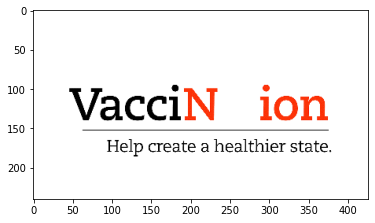

Vaccination_not_detected


In [21]:
# Lets check Tesseract's output on the Initial Image

predict_text(model, image_init, label_dict)

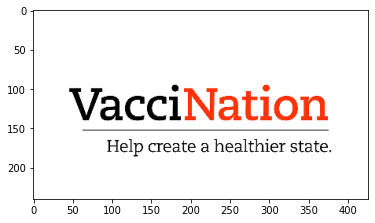

Vaccination_detected


In [22]:
# Lets check Tesseract's output on the Target Image

predict_text(model, image_target, label_dict)

HopSkipJump: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 768.05it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarial image at step 0.
L2 error: 9109.015625
Tesseract output is: Vaccination_not_detected.


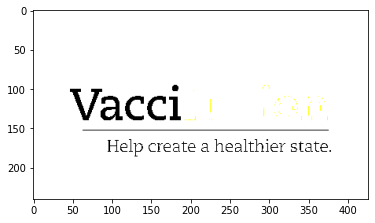

HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:09<00:00, 69.48s/it]


Adversarial image at step 10.
L2 error: 6497.978027
Tesseract output is: Vaccination_not_detected.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


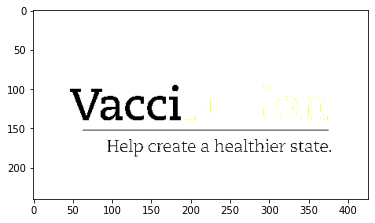

HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:07<00:00, 67.37s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Adversarial image at step 20.
L2 error: 6512.383789
Tesseract output is: Vaccination_not_detected.


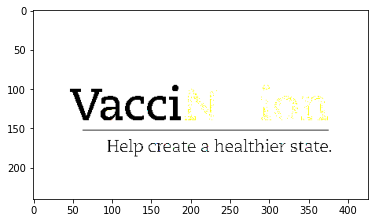

In [26]:
# Adversarial attack using HopSkipJump
'''
Optimization of adversarial image stops after either 15 iterations or 
when the consecutive error does not decrease more than 1%
'''

def create_mask(model, image_init, image_target, label_dict):
    attack = HopSkipJump(classifier=model, targeted=True, norm=2, max_iter=0, max_eval=1000, init_eval=10)
    iter_step = 10
    l2_error_lst = []
    x_adv = np.array([image_init], dtype=np.float32)
    for i in range(15):
        x_adv = attack.generate(x=np.array([image_target], dtype=np.float32), x_adv_init=x_adv, y=to_categorical([1], 3))
        l2_error = np.linalg.norm(np.reshape(x_adv[0]-image_target,[-1]))
        l2_error_lst.append(l2_error)
        print("Adversarial image at step %d." % (i*iter_step))
        print("L2 error: %.6f" %l2_error)
        print("Tesseract output is: %s." % label_dict[np.argmax(model.predict(x_adv)[0])])
        plt.imshow(x_adv[0])
        plt.show(block=False)
        attack.max_iter = iter_step
        if i>=1 and abs(l2_error_lst[-2]-l2_error_lst[-1])/l2_error_lst[-2]<0.01:
            break
    return x_adv, l2_error_lst

adv_img, l2_error_lst = create_mask(model, image_init, image_target, label_dict)


After perturbation


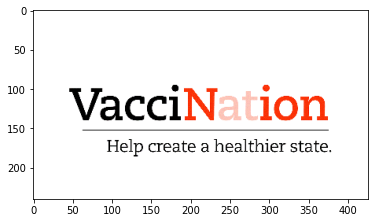

Tesseract output: Vacci

Help create a healthier state.




In [27]:
# Let's verify the created adversarial Image

adv_img_copy = adv_img.astype(np.uint8)
plt.imshow(adv_img_copy[0])
print('After perturbation')
plt.show()
print("Tesseract output: "+pytesseract.image_to_string(adv_img_copy[0,:,:,0]))

In [ ]:
# Save perturbed Image

# perturbed_image_path = './Images/Vaccination/vaccination__perturbed.png'
# imageio.imwrite(perturbed_image_path, adv_img[0])